# Bitshuffle-LZ decompression on GPU

This tutorial explains:

* how to read a HDF5 dataset chunk-by-chunk using the direct-chunk-read feature 
* how to perform the bitshuffle-LZ4 decompression on the GPU using OpenCL.

It uses a stack of 100 frames collected at the ESRF BM29 beamline with a Pilatus 2M, during a HPLC experiment.

In [1]:
%matplotlib inline

In [2]:
# some imports
import time
import h5py
import hdf5plugin
import numpy
from matplotlib.pyplot import subplots
from matplotlib.colors import LogNorm
import silx
from silx.resources import ExternalResources
from silx.opencl.codec.bitshuffle_lz4 import BitshuffleLz4

start_time = time.perf_counter()
print(f"Version of silx used (should be 1.2): {silx.version}")

Version of silx used (should be 1.2): 1.2.0-a0


In [3]:
# Download some data from internet:
filename = ExternalResources("silx", "http://www.silx.org/pub/silx").getfile("hplc.h5")

dataset of shape (100, 1679, 1475) and dtype int32. Images look like:


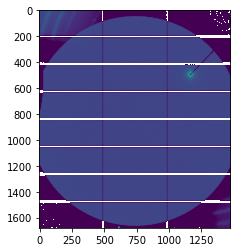

In [4]:
# Display one frame:
fig, ax = subplots()
h = h5py.File(filename)
ds = h["/entry_0000/measurement/data"]
ax.imshow(ds[0], norm=LogNorm())
print(f"dataset of shape {ds.shape} and dtype {ds.dtype}. Images look like:")

In [5]:
# How long does it take to read all frames ?
%timeit for frame in ds: pass

696 ms ± 14.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
# How long does it take to read the raw data (uncompresed) ?
filter_mask, chunk = ds.id.read_direct_chunk(ds.id.get_chunk_info(0).chunk_offset)
%timeit for i in range(ds.id.get_num_chunks()): filter_mask, chunk = ds.id.read_direct_chunk(ds.id.get_chunk_info(i).chunk_offset)
filter_mask, len(chunk)

29.3 ms ± 343 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


(0, 1358315)

In [7]:
# Setup the decompressor on the GPU:
gpu_lz = BitshuffleLz4(len(chunk), numpy.prod(ds.shape[1:]), ds.dtype)
gpu_lz.decompress(chunk)

cl.Array([14, 10, 13, ...,  2,  3,  2], dtype=int32)

True

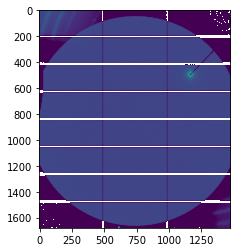

In [8]:
fig, ax = subplots()
frame = gpu_lz.decompress(chunk).get().reshape(ds.shape[1:])
ax.imshow(gpu_lz.decompress(chunk).get().reshape(ds.shape[1:]), norm=LogNorm())
# Validate the decompression on the GPU gives actually the proper result
numpy.all(frame == ds[0])

In [9]:
%%timeit
for i in range(ds.id.get_num_chunks()):
    filter_mask, chunk = ds.id.read_direct_chunk(ds.id.get_chunk_info(i).chunk_offset)
    gpu_lz.decompress(chunk, wg=128)

112 ms ± 343 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
# Some profiling information:
gpu_lz.set_profiling(True)
for i in range(ds.id.get_num_chunks()):
    filter_mask, chunk = ds.id.read_direct_chunk(ds.id.get_chunk_info(i).chunk_offset)
    gpu_lz.decompress(chunk, wg=128)
print("\n".join(gpu_lz.log_profile(stats=True)))


OpenCL kernel profiling statistics in milliseconds for: BitshuffleLz4
                                       Kernel name (count):      min   median      max     mean      std
                                   copy raw H -> D (  100):    0.117    0.118    0.128    0.118    0.002
                                       LZ4 unblock (  100):    0.289    0.293    0.304    0.293    0.003
                                    LZ4 decompress (  100):    0.144    0.146    0.150    0.146    0.001
________________________________________________________________________________
                       Total OpenCL execution time        : 55.774ms


## Conclusion

A speed-up factor 6 has been observed which is mainly due to the (slow) parsing of the input to find the start of the LZ4 blocks. 
The decompression and bit-unshuffling is comparatively fast !
This procedure is mainly worth when subsequent analysis takes place on the GPU, since it saves the time to send the decompressed array.

In [11]:
print(f"Total run-time for the notebook {time.perf_counter()-start_time:.3f}s")

Total run-time for the notebook 18.307s
